# Introduction to SNA: an analysis of co-invention networks

<font size="3">The notebook provides a short introduction to the methods of social network analysis as applied to the network formed by co-inventors. To this purpose, we will use USPTO patent data related to one of the major semiconductor firms in the US.

As a first step, we import libraries. The library `igraph` is the one we need to compute relevant network measures. This library is not the only one in Python that allows SNA. An alternative package is `networkx`.

In [1]:
import pandas as pd
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()
import numpy as np
from igraph import *
import os
import qgrid
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

import rpy2.rinterface
#rpy2.rinterface.set_initoptions((b'rpy2', b'--no-save', b'--no-restore', b'--quiet'))
from rpy2.robjects.packages import importr
base = importr('base')
utils = importr('utils')
igraph = importr('igraph')
print(base._libPaths())
%load_ext rpy2.ipython

[1] "C:/Program Files/R/R-3.2.3/library"



<font size="3">Now, we set the working directory. Please use as working directory the one where you put all data and the notebook file.

In [2]:
os.getcwd()
os.chdir("D:/Dropbox/python/notebooks/20620")
os.getcwd()

'D:\\Dropbox\\python\\notebooks\\20620'

## Importing and inspecting the data

<font size="3">Import the data using the `pandas` library. The first table we import is a list of patents and related inventors.

In [3]:
patid_invid = pd.read_csv('patid_invid.txt', sep='\t')

<font size="3">Let's inspect the data. The table is quite simple: it contains two columns, one refers to the patent document number, the other refers the inventor ID. Of course, if a patent has been authored by more than one inventor, there will be for each patent as many rows as the number of inventors.

In [4]:
qgrid_patinv = qgrid.show_grid(patid_invid, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})
qgrid_patinv

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

<font size="3">The second table we import contains information on the application year of each patent.

In [5]:
patid_date = pd.read_csv('patid_date.txt', sep='\t')
patid_date['appyear'] = pd.to_numeric(patid_date['appyear'])
qgrid_patyear = qgrid.show_grid(patid_date, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})
qgrid_patyear

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

<font size="3">For descriptive purpose, we count the number of patent applications in each year.

In [6]:
patyear = patid_date.groupby('appyear')['patent_id'].count().reset_index()
print(patyear)

    appyear  patent_id
0      1968          1
1      1969          1
2      1970          2
3      1972          8
4      1973         19
5      1974         21
6      1975         21
7      1976         21
8      1977         10
9      1978         18
10     1979         13
11     1980         11
12     1981         23
13     1982         17
14     1983         16
15     1984          8
16     1985         22
17     1986         25
18     1987         52
19     1988         50
20     1989         50
21     1990         74
22     1991        113
23     1992        206
24     1993        322
25     1994        455
26     1995        612
27     1996        831
28     1997        992
29     1998       1079
30     1999       1386
31     2000       1701
32     2001       1806
33     2002       2046
34     2003       2271
35     2004       1978
36     2005       1723
37     2006       1549
38     2007       1245
39     2008        942
40     2009        829
41     2010        765
42     2011

<font size="3">Optionally, we can also plot the same information.

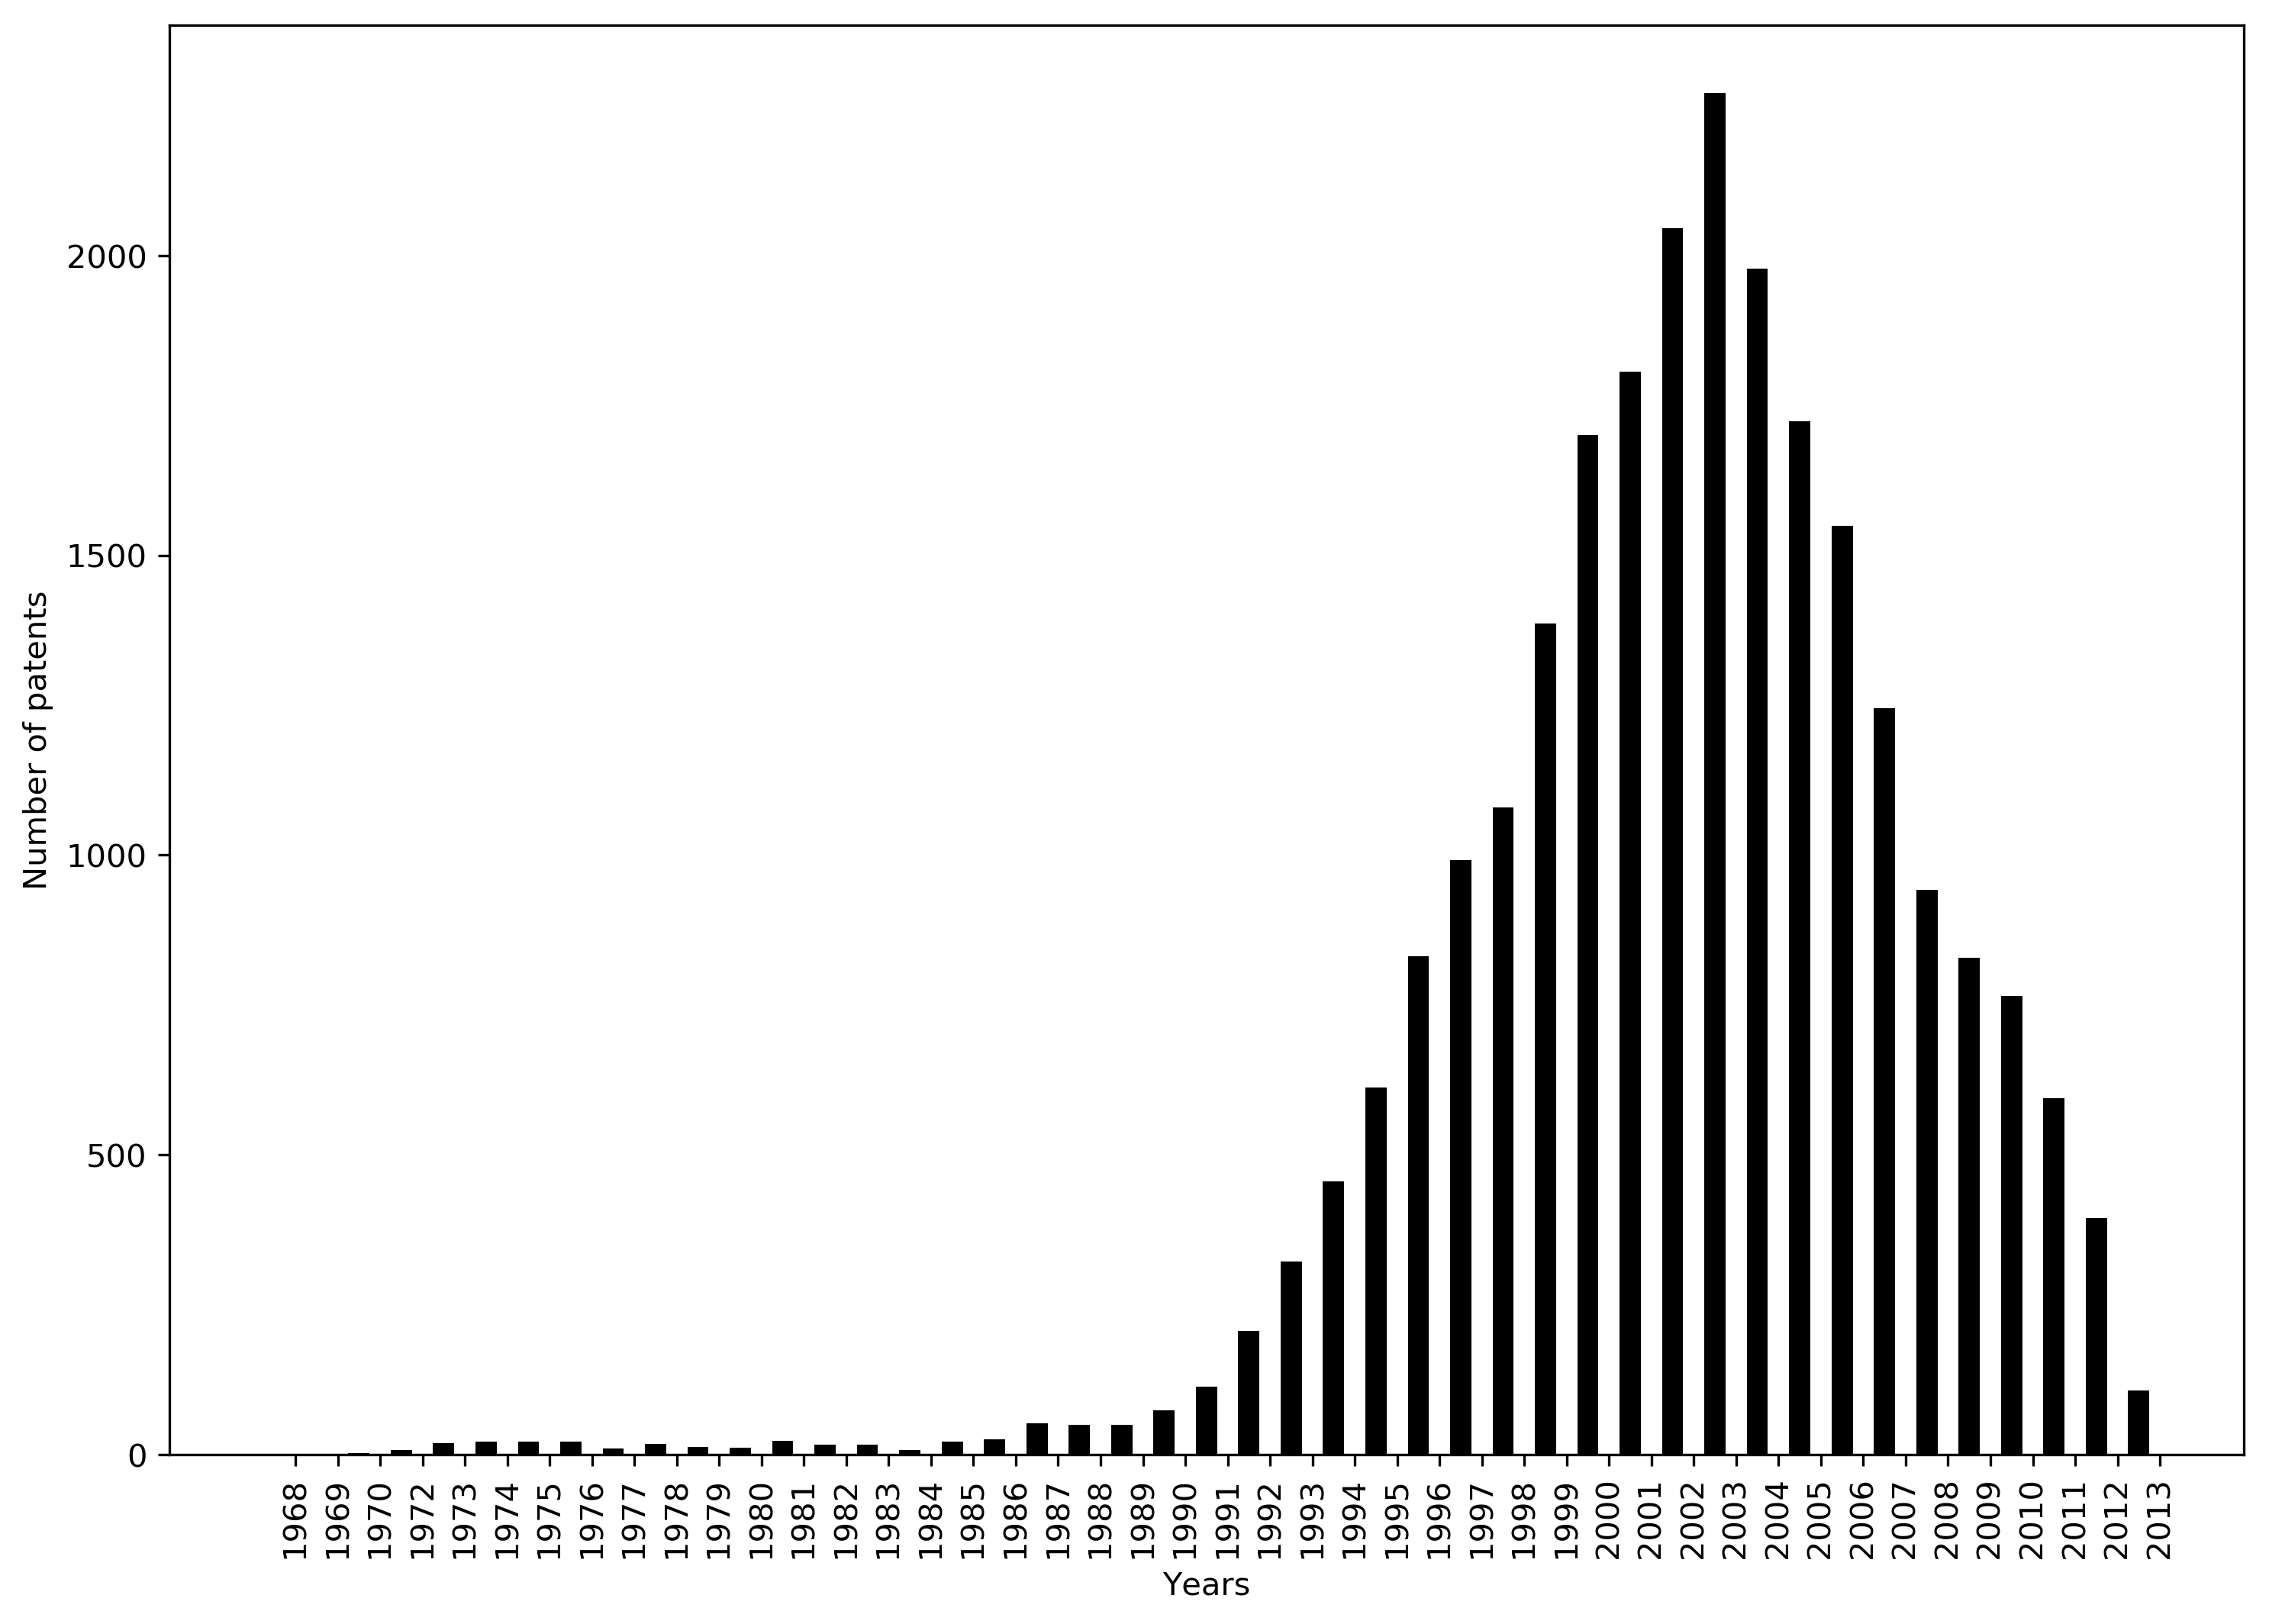

In [7]:
pos = list(range(len(patyear['appyear'])))
width = 0.5
fig = plt.figure(facecolor='white', figsize=(11.69,8.27), dpi=300)
plt.grid(True)
ax = fig.add_subplot(111)

cbar = plt.bar(pos,
               patyear['patent_id'],
               width,
               alpha=1,
color = 'black')

ax.set_ylabel('Number of patents')
ax.set_xlabel('Years')
ax.set_xticks([p + 1 * width for p in pos])
ax.set_xticklabels(patyear['appyear'], rotation=90, ha='center')

plt.grid()
plt.show()

<font size="3">Next, we import the table that contains the technological classes of each patent.

In [8]:
patid_class = pd.read_csv('patid_class.txt', sep='\t')
patid_class = patid_class[patid_class['mainclass_id'].notnull()]
qgrid_patclass = qgrid.show_grid(patid_class, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})
qgrid_patclass

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

<font size="3">Optionally, we can plot the frequencies, keeping only the most important technological classes.

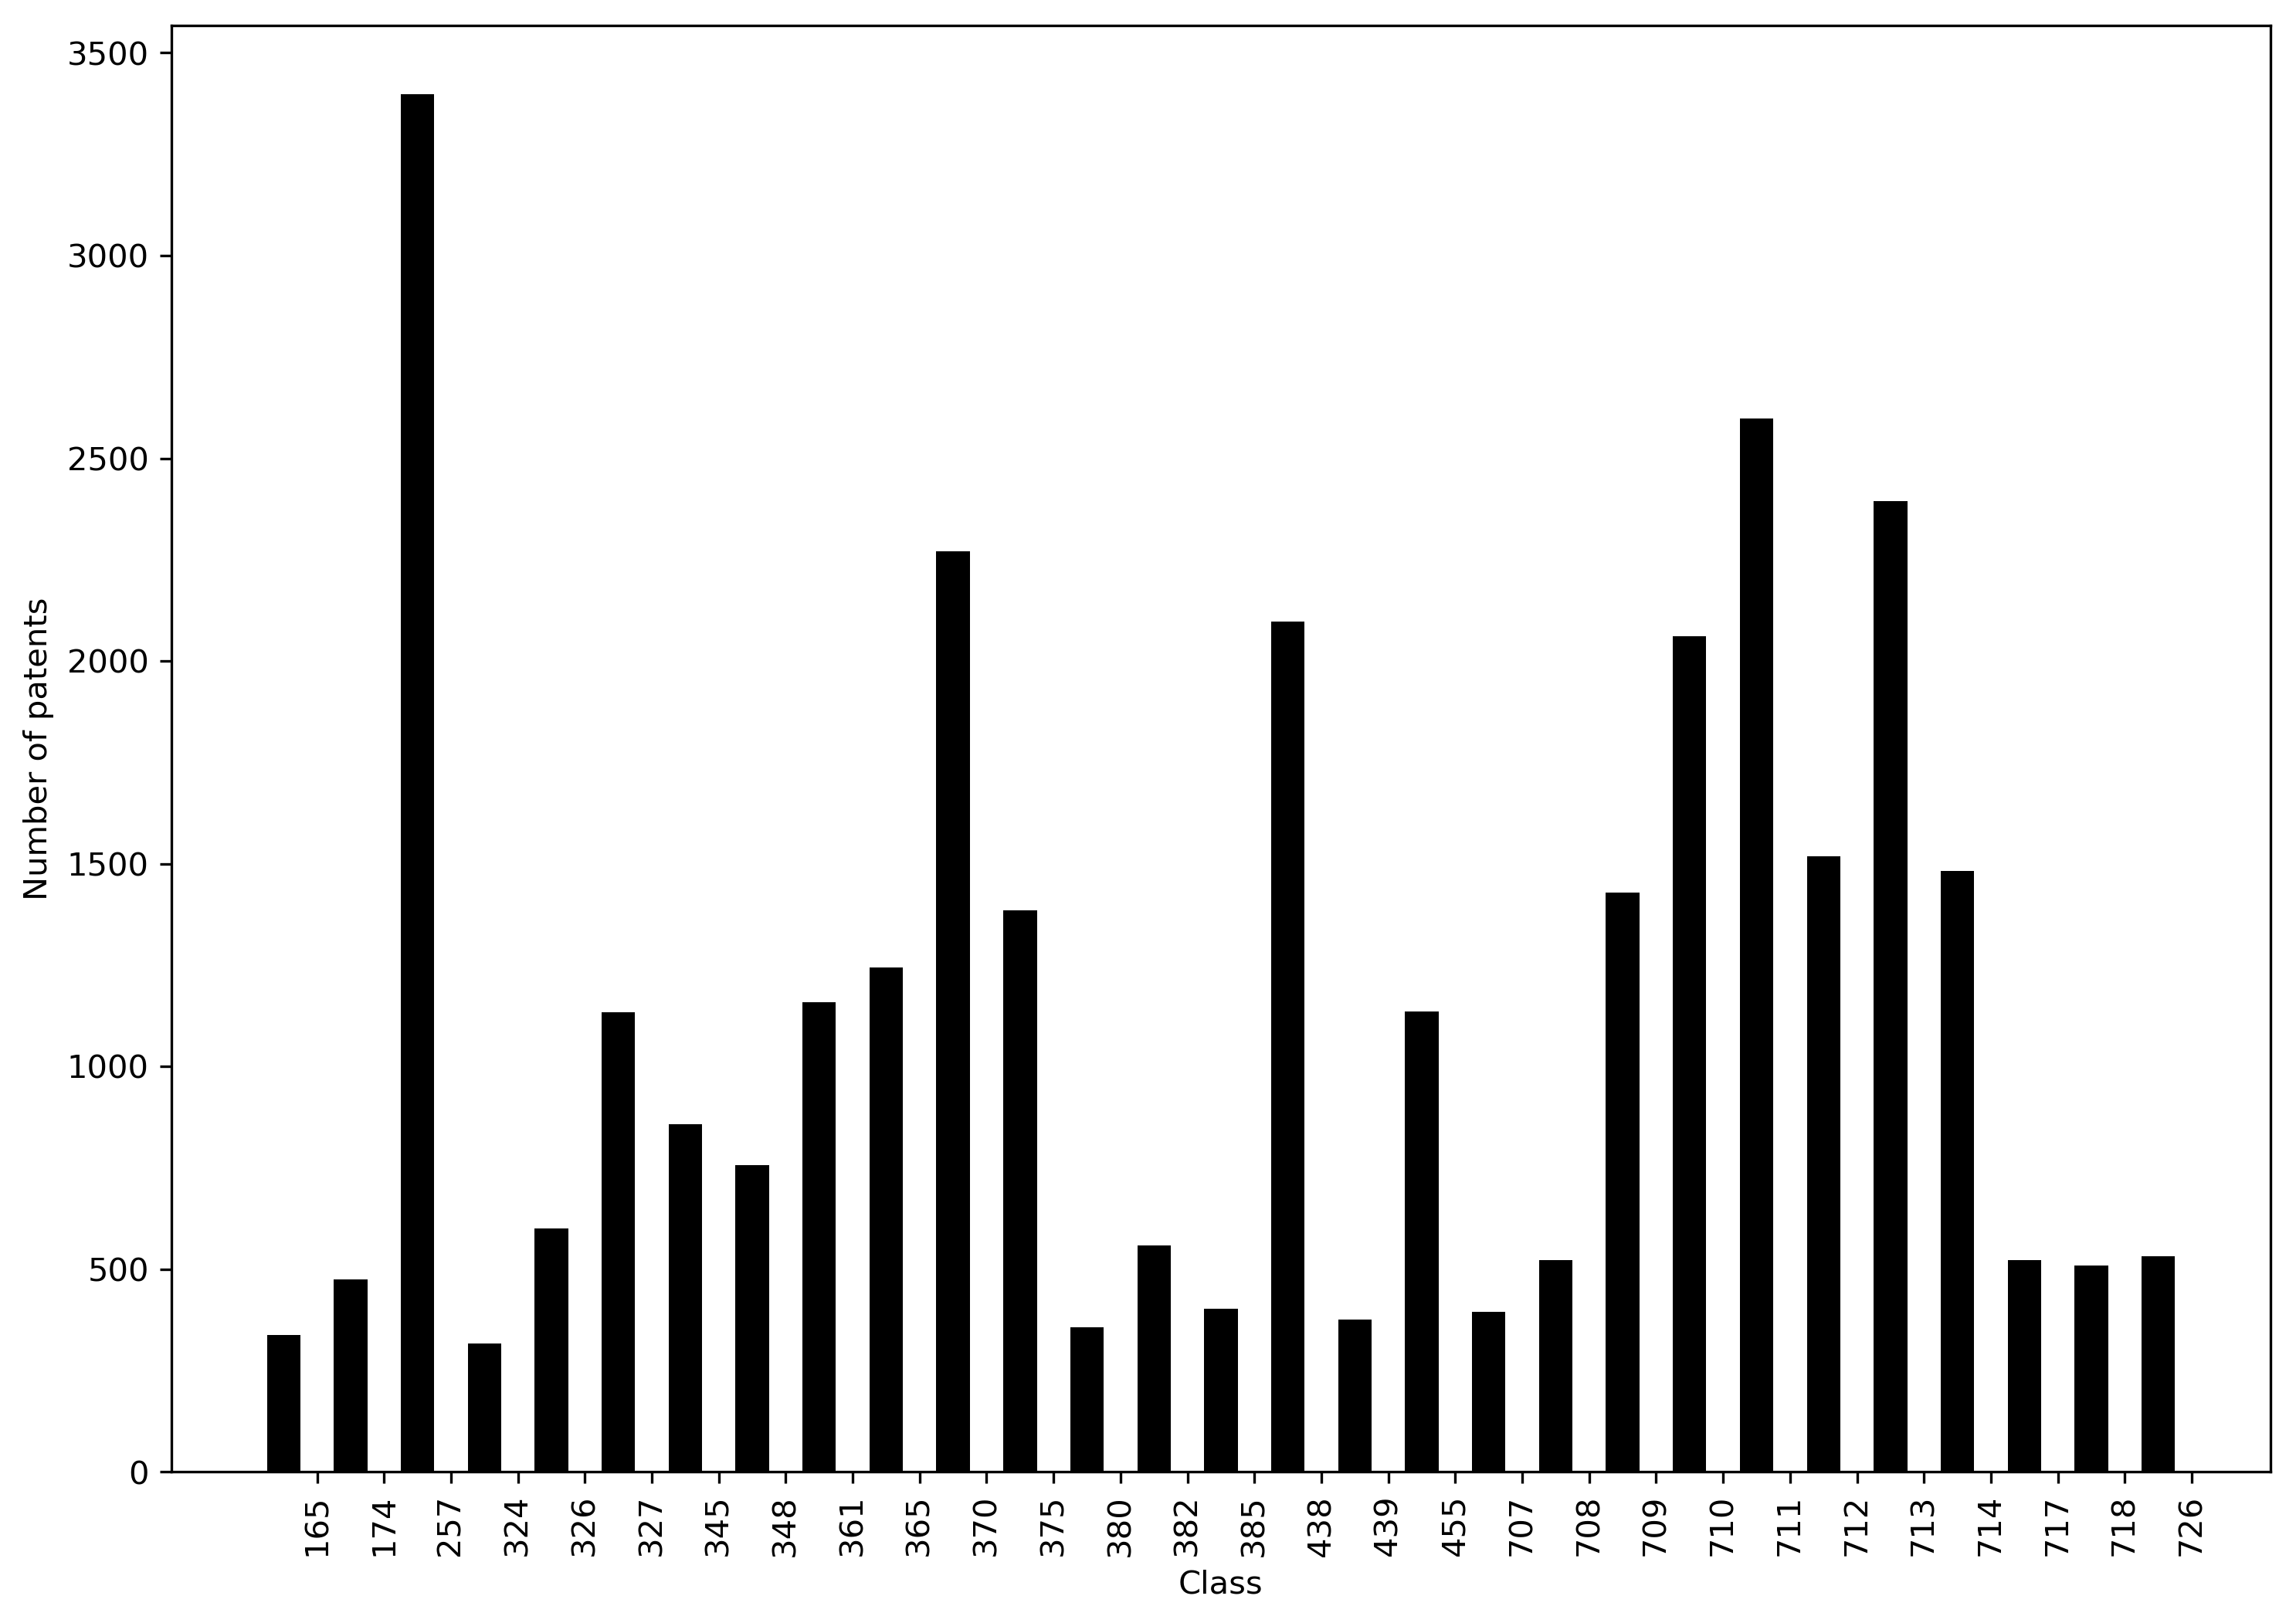

In [9]:
patclass = patid_class.groupby('mainclass_id')['patent_id'].count().reset_index()
patclass = patclass[patclass['patent_id']>300]

pos = list(range(len(patclass['mainclass_id'])))
width = 0.5
fig = plt.figure(facecolor='white', figsize=(11.69,8.27), dpi=300)
plt.grid(True)
ax = fig.add_subplot(111)

cbar = plt.bar(pos,
               patclass['patent_id'],
               width,
               alpha=1,
color = 'black')

ax.set_ylabel('Number of patents')
ax.set_xlabel('Class')
ax.set_xticks([p + 1 * width for p in pos])
ax.set_xticklabels(patclass['mainclass_id'], rotation=90, ha='center')

plt.grid()
plt.show()

<font size="3">The technological class where the company is patenting most is class 257. From the USPTO patent office, we realize that this class refers to active solid state devices (i.e. semiconductors).

https://www.uspto.gov/web/patents/classification/uspc257/sched257.htm


<font size="3">At this point, we can merge the various tables. The resulting table contains four columns: patent number, inventor ID, application year and technological class. 

In [10]:
patinvyear = pd.merge(patid_invid, patid_date, how='left', on='patent_id')
patinvyear = pd.merge(patinvyear, patid_class, how='left', on='patent_id')
patinvyear = patinvyear[patinvyear['appyear'].notnull()]
patinvyear = patinvyear[patinvyear['mainclass_id'].notnull()]
patinvyear = patinvyear[patinvyear['patent_id'].notnull()]
patinvyear = patinvyear[patinvyear['inventor_id'].notnull()]
patinvyear = patinvyear.drop_duplicates()
qgrid_patinvyear = qgrid.show_grid(patinvyear, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})
qgrid_patinvyear

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

## Building the co-invention network

<font size="3">In order to build the co-invention network, we take a slice of the data. In particular, it is quite standard in the literature to take a rolling window of 5 years in order to build networks of co-invention (but also strategic alliances, etc.). In this way, we assume that the relations that matter at some year $t$ are those that took place in the period between $t-1$ and $t-5$ and that the relations that occurred earlier, e.g. at time $t-6$, are no longer in place. The choice is obviously quite arbitrary. Yet, absent information on the duration of relations, it is a reasonable assumption.

For example, take the year $2000$ and imagine that we want to assess the impact on some event (e.g. performance etc.) in that year of the existing network of relations of each individual. Following the convention discussed above, we will build the co-invention network by considering the patents made in the period $1995-1999$.

<br>
We need to subset the data.

In [11]:
j = 2000
win = 5
sample = patinvyear.copy()
sample = sample[(sample['appyear'] >= j-win) & (sample['appyear'] < j)]
sample = sample[['patent_id', 'inventor_id']].drop_duplicates()

<font size="3">Now, we count the number of inventors contained in each patent.

In [12]:
invxpat = sample.copy()
invxpat.columns = ['patent', 'bx']
invxpat = invxpat.groupby('patent')['bx'].count().reset_index()
invxpat.columns = ['patent', 'totinv']
print(invxpat.head(5))

    patent  totinv
0  5453708       2
1  5455794       5
2  5455957       2
3  5471605       1
4  5471637       3


<font size="3">We are going to build a co-invention network where the vertices of the network are inventors. First of all, we count that will be contained in the network (including isolates, i.e. inventors without any co-inventor). In the period considered, we have 3278 inventors.

In [13]:
nr_vertices = len(sample[['inventor_id']].drop_duplicates())
print('Number of vertices (inventors) including isolates', nr_vertices)
all_inventors = sample.copy()
all_inventors = all_inventors[['inventor_id']].drop_duplicates()

Number of vertices (inventors) including isolates 3278


<font size="3">We are now ready to build the co-inventork for the period selected. To this purpose, note that the co-invention network is technically speaking a two-mode or affiliation network. This means that inventors are connected to each other "through" their common affiliation to one or more patents. The idea is illustrated in the figure below.

<img src="affiliation.png" alt="Affiliation network" title="Title text" />

<font size="3">Following the insight above, to build the co-invention network, we need to construct a so-called edgelist. This is a list where each pair of inventors is linked if they have at least one patent in common.

In [14]:
edgelist = pd.merge(sample, sample, how='left', on=['patent_id'])
edgelist.columns = ['patent', 'bx', 'by']
print(edgelist.head(10))

    patent         bx         by
0  5453708  4415817-1  4415817-1
1  5453708  4415817-1  5453708-1
2  5453708  5453708-1  4415817-1
3  5453708  5453708-1  5453708-1
4  5455794  5057715-3  5057715-3
5  5455794  5057715-3  5065364-1
6  5455794  5057715-3  5233559-1
7  5455794  5057715-3  5262990-5
8  5455794  5057715-3  5306963-2
9  5455794  5065364-1  5057715-3


<font size="3">We attach to this table, the information computed above on the number of inventors for each patent. Moreover, we also compute a weight that summarizes the strength of the relation between inventors on each patent. To this purpose, we follow Newman (2001), a define the following weight: <br>
$$\frac{1}{n_k-1}$$
<br>
where $n_k$ is the number of inventors in patent $k$.

In [15]:
edgelist = pd.merge(edgelist, invxpat, how='left', on='patent')
edgelist['wn'] = np.where(edgelist['totinv']>1, 1 / (edgelist['totinv'] - 1), 1)
print(edgelist.head(10))

    patent         bx         by  totinv    wn
0  5453708  4415817-1  4415817-1       2  1.00
1  5453708  4415817-1  5453708-1       2  1.00
2  5453708  5453708-1  4415817-1       2  1.00
3  5453708  5453708-1  5453708-1       2  1.00
4  5455794  5057715-3  5057715-3       5  0.25
5  5455794  5057715-3  5065364-1       5  0.25
6  5455794  5057715-3  5233559-1       5  0.25
7  5455794  5057715-3  5262990-5       5  0.25
8  5455794  5057715-3  5306963-2       5  0.25
9  5455794  5065364-1  5057715-3       5  0.25


<font size="3">Because inventors may have collaborated on more than one patent, we collapse the previous edgelist by summing up for each pair of inventors. The weight capturing the strength of the relation is thus defined as:<br>
    
$$\frac{δ_i^kδ_j^k}{n_k-1}$$
<br>
where $δ_i^k$ is equal to $1$ if inventor $i$ was a co-author of patent $k$, and $n_k$ is the number of co-inventors of patent k. We also compute the inverse of the weight.

In [16]:
edgelist = edgelist.groupby(['bx', 'by'])['wn'].sum().reset_index()
edgelist['iwn'] = 1 / edgelist['wn']
edgelist['w'] = 1
print(edgelist.head(10))

          bx         by        wn       iwn  w
0  3879668-1  3879668-1  0.333333  3.000000  1
1  3879668-1  5416799-1  0.333333  3.000000  1
2  3879668-1  5663734-1  0.333333  3.000000  1
3  3879668-1  6298098-1  0.333333  3.000000  1
4  3906347-2  3906347-2  1.000000  1.000000  1
5  3943287-2  3943287-2  3.233333  0.309278  1
6  3943287-2  4993958-1  0.500000  2.000000  1
7  3943287-2  5392285-1  0.400000  2.500000  1
8  3943287-2  5410710-1  0.400000  2.500000  1
9  3943287-2  5513338-1  0.400000  2.500000  1


<font size="3">For each pair of inventors, we have now 3 types of weights:<br>
1. `wn` measures of the strength of the relation between inventor $i$ and $j$; the weight is greater if the inventors have collaborated on a large number of patents, possibily with few other co-authors;
2. `iwn` is simply the inverse of `wn`
3. `w` is a binary weight, 0/1. It takes value 1 if two inventors collaborated (irrespective of the number of patents), it is equal to 0 if they did not. <br>
Technically speaking, if we take into account the weight `wn` we are considering a _weighted_ _undirected_ (i.e. the edges connecting inventors do not have a directionality) network. On the other hand, if we consider the weight `wn` the network is defined as a _binary_ _undirected_ network.

<br>
For simplicity, in what follows, we consider a binary network.

In [17]:
binary = edgelist.copy()
binary = binary[['bx', 'by', 'w']].drop_duplicates()

<font size="3">In order to convert the edgelist to a `igraph` object, we need first to convert the `pandas` table to list (of lists).

In [18]:
binary = binary.values.tolist()
print(binary[0:10])

[['3879668-1', '3879668-1', 1], ['3879668-1', '5416799-1', 1], ['3879668-1', '5663734-1', 1], ['3879668-1', '6298098-1', 1], ['3906347-2', '3906347-2', 1], ['3943287-2', '3943287-2', 1], ['3943287-2', '4993958-1', 1], ['3943287-2', '5392285-1', 1], ['3943287-2', '5410710-1', 1], ['3943287-2', '5513338-1', 1]]


<font size="3">Finally, we can create `igraph` object: in the code below `ig` is our graph.

In [19]:
ig = Graph.TupleList(binary, edge_attrs = 'w', directed=False)

<font size="3">As the graph contains "loops", i.e. edges starting and ending to the same vertex, we remove them.

In [20]:
print(ig.has_multiple())
ig.simplify(multiple=True, loops=True, combine_edges="first")

True


<font size="3">Let's plot the network. To this purpose, we use the igraph library in R (as the python igraph library has some issues in Jupyter).

First of all, we convert the edge list to an R data frame.

In [21]:
edgelist_r = ig.get_edgelist()
edgelist_r = pd.DataFrame(edgelist_r)
edgelist_r.columns = ['a', 'b']
edgelist_r = pandas2ri.py2ri(edgelist_r)
#print(edgelist_r)

<font size="3">Then, we import the object to R, we convert to igraph and we plot.

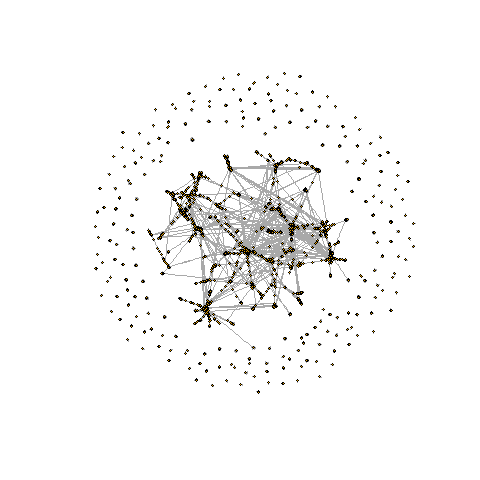

In [22]:
%%R -i edgelist_r
#install.packages("igraph", "C:/Program Files/R/R-3.2.3/library")
library(igraph)
g <- graph.data.frame(edgelist_r, directed=FALSE)
plot(g, vertex.size=2,  vertex.label=NA)

<font size="3">The graphical plot is not particularly useful. It reveals that there is a major cluster of inventors in the network and many smaller clusters. In order to characterize the topological properties of the network is more useful to compute a few summary measures.

## Network level topological properties

<font size="3">First of all, we can simply count the number of vertices (i.e. inventors) and edges (i.e. ties linking inventors) in the network.

In [23]:
print('Number of vertices', ig.vcount())
print('Number of edges', ig.ecount())

Number of vertices 3278
Number of edges 7163


### Density

<font size="3"> Density is defined as the number of existing edges out of the total poissble number of edges.
$$\frac{2*E}{n*(n-1)}$$

In [24]:
print('Density of the network (%)', 100*ig.density())

Density of the network (%) 0.1333642896866749


### Average path length

<font size="3">A relevant measure that captures the structure of the network is the so-called _average path length_. In order to understand this measure, we need to introduce a few definitions.
    
In social network analysis it is often important to know whether it is possible to reach some node $n_i$ from another node $n_j$ (e.g. communication of information among employees in an organization). The concept of walks, trails and __paths__ are building blocks to study the __connectivity__ of graphs, the __distance__ between pairs of nodes and the edges that are critical for the connectivity of the graph.

A few definitions:

- A walk is a sequence of (adjacent) nodes and lines starting and ending with nodes (walks are unrestricted, i.e. a walk can involve the same actor or line more than once(. 
- A trail is a walk in which all the lines are distinct, though some nodes may be used more than once
- A __path__ is a walk in which all nodes and all lines are distinct: if there is a path between nodes $n_i$ and $n_j$, then the two nodes are said to be __reachable__.

The length of a walk (trail, path) is the __number of lines__ that occur in it.

In the example below, the __length__ of the __path__ between $n_1$ (Jack) and $n_2$ (Jeff) is 2.

<img src="paths.png" alt="Paths" title="Title text" />


Note that there are two ways to go from $n_1$ (Jack) and $n_2$ (Jeff): one is the path ${n_1}{n_4}{n_2}$, the other is the path  ${n_1}{n_4}{n_3}{n_2}$. The length of the former is 2, while the length of the latter is 3. The path ${n_1}{n_4}{n_2}$ is the __shortest path__ (or __geodesic__) between $n_1$ and $n_2$.

The geodesic distance $d(n_i,n_j)$ between two nodes is simply the length of the shortest path connecting them. If there is no path between two nodes (i.e. they are not reachable) then the distance between them is infinite (or undefined).

The __diameter__ of a graph is the length of the largest geodesic between any pair of nodes. The diameter of a graph can range from a minimum of 1 to a maximum of $(g-1)$, where $g$ is the number of nodes in the network, or infinite (undefined) if the graph is disconnected.

The __average path length__ is the average length of the geodesics between any pair of nodes. We can easily compute the average path length in our newtork.

In [25]:
print('Average path length: ', ig.average_path_length())

Average path length:  6.634322489137696


<font size="3">In our co-invention network, inventors are on average six steps away from each other.

In [26]:
diameter = len(ig.get_diameter(directed=False))
print('Diameter of the network: ', diameter)

Diameter of the network:  20


### Degree distribution. 

<font size="3">The degree of a node is the number of nodes that are adjacent with it (i.e. its neighbours). Nodal degree is a measure of how well connected (or ‘active’) a node is in the network. It ranges fom a minimum of $0$ (isolate) to a maximum of $(g-1)$, where $g$ is the number of nodes in the network. Nodal degrees (and their distribution) are an important property of the graph as a whole.

In [27]:
degree = ig.degree()
degree = pd.DataFrame(degree)
degree.columns=['degree']
degree['count'] = 1
degree = degree.groupby('degree')['count'].sum().reset_index()
degree

,degree,count
0,0,311
1,1,578
2,2,596
3,3,410
4,4,300
5,5,227
6,6,193
7,7,138
8,8,101
9,9,84


<font size="3">The degree distribution shows that there are 311 isolates. Moreover, the distribution is quite skewed. The vast majority of inventors have few co-authors, whereas few of them have a very large number of collaborators. 
    
Let's identify and select isolates (i.e. inventors without any co-inventor, degree==0). To this purpose, we use a python function.

In [28]:
def inv_list(grafo):
    listinv = []
    for v in grafo.vs:
        ind = v.index
        vert = v['name']
        tott = (ind, vert)
        listinv.append(tott)
    inv = pd.DataFrame(listinv)
    inv.columns = ['vertex_idx', 'inventor_id']
    return inv

degree = ig.degree()
ig_vs = ig.vs.select([v for v, b in enumerate(degree) if b == 0]) 
print('Number of isolates: ', len(ig_vs))
isolates = ig.copy()
isolates = isolates.subgraph(ig_vs)
isolates = inv_list(isolates)
isolates

Number of isolates:  311


,vertex_idx,inventor_id
0,0,3906347-2
1,1,3944926-1
2,2,3955353-1
3,3,4495537-1
4,4,4549292-2
5,5,4654958-3
6,6,4736239-2
7,7,4785428-3
8,8,4819081-3
9,9,4875191-1


<font size="3">Now, we remove the isolates from the graph.

In [29]:
degree = ig.degree()
ig_vs = ig.vs.select([v for v, b in enumerate(degree) if b > 0]) 
ig = ig.subgraph(ig_vs)
inv = inv_list(ig)
print('Number of inventors after removing isolates: ', ig.vcount())

Number of inventors after removing isolates:  2967


### Clustering

<font size="3">Informally, it measures to what extent “my friends are also friends to each other”. In our context, it measures the extent to which an inventor's collaborators are also partners with each other.

More formally, the clustering coefficient of a node (ego) is defined as the ratio between the number of actual edges among its neighbours (excluding ego) and the number of possible edges among them:
<br>

$$C_i=\frac{2*E_{jk}}{k_i*(k_i-1)}$$

<br>
where $k_i$ is the degree of node $i$ (i.e. the number of its neighbours) and $E_{jk}$ is the actual number of edges connecting its neighbours.

<img src="clustering.png" alt="CC" title="Title text" />

The clustering coefficient for the whole network is given as the simple average of the clustering coefficient for each vertex.

$$CC=\frac{1}{g}\sum_{i=1}^{g}C_i$$

In [30]:
clustcoeff = ig.transitivity_avglocal_undirected()
print('Clustering coefficient: ', clustcoeff)

Clustering coefficient:  0.7115921824155811


<font size="3">The value of the CC in our network is large: on average 71% of triples of nodes are also triangles, i.e. if $a--b$, and $a--c$, then also $b--c$. The co-invention network looks like a __small world__: inventors tend to form local cohesive clusters, but there are shortcuts linking clusters of inventors so that the average distance between them is low.

### Number of components and largest connected component

<font size="3">An important property of a graph is whether or not it is connected. A graph is connected if there is a path between every pair of nodes, i.e. all pairs of nodes are reachable.
    
A component is a maximal connected subgraph in which every node can reach every other by some path (no matter how long). A subgraph is a subset of nodes and lines in the graph, such that all lines are between pairs of nodes in the subset. A subgraph is maximal with respect to some property if that property holds for the subgraph, but does not hold if any other node is added to the subgraph.
<br>
<img src="component.png" alt="Components" title="Title text" />


In [31]:
# extract components and sequence of vertices
# note: the command creates a vertex attribute named 'cluster'
ig.vs['cluster'] = ig.clusters().membership
# number of connected components (including isolates)
components = max(ig.vs['cluster']) + 1
print('Number of connected components: ', components)

# size of largest component
nv = ig.vcount()
lclust = ig.clusters(mode='weak')
lcc = lclust.giant()
print('Number of inventors in the largest connected component: ', lcc.vcount())
largest = 100*lcc.vcount() / nv
print('Size of largest component as percentage of all inventors in the company: ', largest)

Number of connected components:  224
Number of inventors in the largest connected component:  2258
Size of largest component as percentage of all inventors in the company:  76.10380856083586


<font size="3">Most inventors (76%) are located in the largest connected component of the network, i.e. there is a finite path connecting them. We extract the largest component of the network and we plot it.

In [32]:
edgelist_r = lcc.get_edgelist()
edgelist_r = pd.DataFrame(edgelist_r)
edgelist_r.columns = ['a', 'b']
edgelist_r = pandas2ri.py2ri(edgelist_r)
#print(edgelist_r)

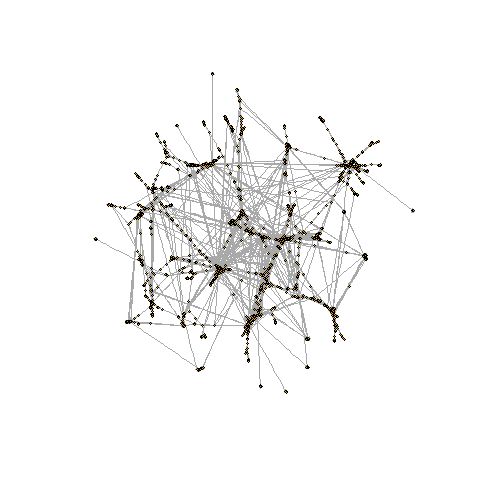

In [33]:
%%R -i edgelist_r
#install.packages("igraph", "C:/Program Files/R/R-3.2.3/library")
library(igraph)
g <- graph.data.frame(edgelist_r, directed=FALSE)
plot(g, vertex.size=2,  vertex.label=NA)

## Node level measures

<font size="3">So far, we have examined some measures that capture the overall structure of the network. In what follows, we consider the position of each individual node (i.e. inventor) in the network. 

### Centrality

<font size="3">We start from the centrality measures. In general, these measures capture how _important_ or _prominent_ is a node in the network. 

We have already defined one of these measures, i.e. the degree centrality. In this respect, an actor is central if it has a large number of ties to other actors in the network. Yet, this is not the only concept of centrality.
    
Here, we introduce two other measures, __betweenness centrality__ and __closeness centrality__.

The concept of __betweenness centrality__ measures the extent to which an actor has some control over interactions among other actors in the network, i.e. it lies between other actors on their geodesics. It is an index of potential for gatekeeping, brokering, controlling the flow, and also of liaising otherwise separate parts of the network. Formally, it is defined as:

$$C_B(n_i)=\sum_{j<k}\frac{g_{jk}(n_i)}{g_{jk}}$$

where $g_{jk}$ is the number of shortest paths connecting nodes $j$ and $k$ and $g_{jk}(n_i)$ is the number of shortest paths that pass through node $n_i$. It measures how often a node lies along the shortest path between two other nodes.
The betweenness centrality has a minimum of $0$ (i.e. the node falls on no geodesics) and a maximum of $(g-1)(g-2)/2$ (i.e. the total number of pairs of actors excluding $n_i$).

<img src="centrality.png" alt="Components" title="Title text" />


The concept of closeness centrality refer to actors that can _quickly_ interact with all others, i.e. they are close to all other actors in the network. Formally it is defined as the (inverse of) the sum of distances to all other actors:

$$C_C(n_i)=\Big[ \sum_{j=1}^g{d(n_{i}n_{j})}\Big]^{-1}$$

The index has a maximum at $(g-1)^{-1}$, i.e. the actor is adjacent to all other nodes.

We now compute the centrality measures in our co-invention network (remember that we have dropped the isolated inventors).

In [34]:
def net_measure(data, method, measure):
    tmp = method
    tmp = pd.DataFrame(tmp)
    tmp['vertex_idx'] = tmp.index
    tmp = pd.merge(tmp, inv, how='left', on='vertex_idx')
    tmp.columns = [measure, 'vertex_idx', 'inventor_id']
    return tmp

inv = inv_list(ig)
degree = net_measure(ig, ig.degree(), 'degree')
betweenness = net_measure(ig, ig.betweenness(), 'betweenness')
closeness = net_measure(ig, ig.closeness(normalized=False), 'closeness')
nodal_measures = pd.merge(degree, betweenness, how='left', on=['inventor_id', 'vertex_idx'])
nodal_measures = pd.merge(nodal_measures, closeness, how='left', on=['inventor_id', 'vertex_idx'])

<font size="3">We normalize the measures.

In [35]:
nr_vertices = ig.vcount()
nodal_measures['betweenness'] = 100 * 2 * nodal_measures['betweenness'] / ((nr_vertices-1) * (nr_vertices-2))
nodal_measures['closeness'] = nodal_measures['closeness'] * (nr_vertices-1)
nodal_measures = nodal_measures[['vertex_idx', 'inventor_id', 'degree', 'betweenness', 'closeness']]
nodal_measures

,vertex_idx,inventor_id,degree,betweenness,closeness
0,0,3879668-1,3,0.000000,0.000337
1,1,5416799-1,3,0.000000,0.000337
2,2,5663734-1,3,0.000000,0.000337
3,3,6298098-1,3,0.000000,0.000337
4,4,3943287-2,10,2.013641,0.001402
5,5,4993958-1,4,0.086308,0.001401
6,6,5392285-1,5,0.000000,0.001402
7,7,5410710-1,24,2.534083,0.001403
8,8,5513338-1,5,0.000000,0.001402
9,9,5535094-2,3,0.000000,0.001401


In [36]:
corr = nodal_measures.corr(method='pearson')
corr

,vertex_idx,degree,betweenness,closeness
vertex_idx,1.000000,-0.431741,-0.254312,-0.340758
degree,-0.431741,1.000000,0.679291,0.278386
betweenness,-0.254312,0.679291,1.000000,0.163535
closeness,-0.340758,0.278386,0.163535,1.000000


### Brokerage

<font size="3">The concept of brokerage dates back at least to the seminal work of Granovetter (1973) on the strength of weak ties. The idea is that the control over bridging ties in a social network may confer significant advantages to actors. In other words, an actor’s brokerage depends on being incident to (i.e. have a command upon) edges that bridge otherwise disconnected others.
    
One of the most important and widely known measures of social brokerage is the so-called Burt constraint index (a.k.a. autonomy) (Burt, 1992). This is formally defined as:

$$BC_i = \sum_{j}\big(p_{ij} + \sum_{i\neq{q}\neq{j}}p_{iq}p_{qj}\big)^2$$

where $BC_i$ is the network constraint of actor $i$, $p_{ij}$ is the proportion of time and energy devoted by actor $i$ to her interaction with actor $j$, and $p_{iq}$ and $p_{qj}$ are defined in a similar way.

The measure ranges from a minimum of 0 (no constraint, highest brokerage) to a maximum of 2. Higher values of the constraint index $BC_i$ indicate that actor $i$ is embedded in a highly cohesive network of relations, i.e. either her links are concentrated on few other actors or her strongest relations are with partners that are strongly tied to her other partners. 

In this sense, the constraint index has to be viewed as an inverse measure of brokerage.

An important point to note is that Burt constraint is a brokerage measure that takes into consideration only the local network surrounding an actor, i.e. the so-called ego-network. The ego-network of an actor is represented by the focal actor (“ego”), by the other actors to whom the focal actor is connected (“alters”) and by the ties (if any) between the alters. As a consequence, the measure captures the extent of embeddedness in “local” social structures, but it does not say anything about the position of the actor in the entire network of relations beyond her immediate neighborhood.

To illustrate the calculation of the index, consider the following example.

<img src="burt_example.png" alt="Burt" title="Title text" />

The Burt constraint values are:

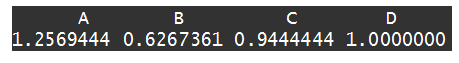

Below, the details of how computing the index for node B.

<img src="burt_calculation.png" alt="Burt" title="Title text" />

Below, we compute the burt constraint index for the inventors in our network.

In [37]:
burt = net_measure(ig, ig.constraint(), 'burt')
nodal_measures = pd.merge(nodal_measures, burt, how='left', on=['inventor_id', 'vertex_idx'])
nodal_measures

,vertex_idx,inventor_id,degree,betweenness,closeness,burt
0,0,3879668-1,3,0.000000,0.000337,0.925926
1,1,5416799-1,3,0.000000,0.000337,0.925926
2,2,5663734-1,3,0.000000,0.000337,0.925926
3,3,6298098-1,3,0.000000,0.000337,0.925926
4,4,3943287-2,10,2.013641,0.001402,0.211512
5,5,4993958-1,4,0.086308,0.001401,0.394202
6,6,5392285-1,5,0.000000,0.001402,0.443141
7,7,5410710-1,24,2.534083,0.001403,0.092083
8,8,5513338-1,5,0.000000,0.001402,0.443141
9,9,5535094-2,3,0.000000,0.001401,0.538657


<font size="3">Next, we identify the inventor with the lowest value of constraint (i.e. the one with highest brokerage) and we plot his/her ego-network.

In [38]:
min_burt = burt['burt'].min()
print('Lowest value of Burt constraint ', min_burt)
print('Inventor with the lower value of constraint')
print(nodal_measures[nodal_measures['burt']==min_burt][['vertex_idx', 'inventor_id']])
focinv = nodal_measures[nodal_measures['burt']==min_burt][['inventor_id']].values.flatten()

Lowest value of Burt constraint  0.04259131486912993
Inventor with the lower value of constraint
     vertex_idx inventor_id
245         245   5561780-3


In [39]:
neigh = ig.neighborhood(vertices=245)
neigh = ig.induced_subgraph(neigh)
#print(neigh.vs[0]["name"])
# index of focal inventor in the induced subgraph
focal = neigh.vs.find(focinv[0])
focal = focal.index
print('Index of focal inventor ', focal)
edgelist_r = neigh.get_edgelist()
edgelist_r = pd.DataFrame(edgelist_r)
edgelist_r.columns = ['a', 'b']
edgelist_r = pandas2ri.py2ri(edgelist_r)
#print(edgelist_r)
# list of vertices
vlist = []
for k in neigh.vs:
    idx = k.index
    vlist.append(idx)
vlist = pd.DataFrame(vlist)
vlist.columns = ['vertex']
vlist['size'] = 4
vlist['size'] = np.where(vlist['vertex'] == focal, 10, vlist['size'])

Index of focal inventor  14


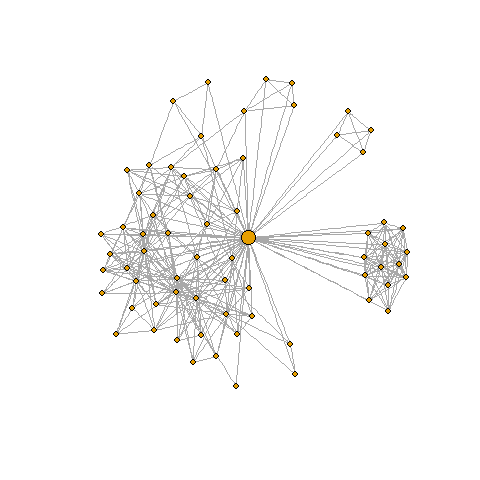

In [40]:
%%R -i edgelist_r -i vlist
#install.packages("igraph", "C:/Program Files/R/R-3.2.3/library")
library(igraph)
g <- graph.data.frame(edgelist_r, directed=FALSE)
vlist = vlist[,c("size")]
plot(g, vertex.size=vlist,  vertex.label=NA)
#plot(g, vertex.size=constraint(g),  vertex.label=NA)

## Two "toy" applications

<font size="3">Here, we carry out two "toy" applications of the methods shortly reviewed above. The applications are fairly simple and not rigorous. Yet they provide an idea of how the methods of social network analysis might be used to answer real world questions.
    
The first application we examine concerns the diffusion of knowledge, the second one regards the relation between innovation and structural position in the network.

### Diffusion of knowledge

<font size="3">In this application, we test to what extent the diffusion of knowledge, as measured by patent citations, is driven be the "social" distance between inventors. In particular, our expectation (or hypothesis) is that _the greater the social distance between inventors, the less likely they are to cite each other_. In this respect, we replicate results in Singh (2005) and Breschi-Lissoni(2004, 2009).
    
To this purpose, we keep on using the patent data of the semiconductor firm examined above. To speed-up computing time, we focus on a single year. In particular, we take all patents made by the focal company in __1995__ and we extract all prior art patent documents cited by these patents.

We take into account only patents (citing or cited) made by the focal company. In other words, we exclude cited patents made by other companies. This means that we focus on company self-citations, i.e. on how the knowledge circulates within the boundaries of the firm. This choice is dictated uniquely by convenience, as it allows us to reduce computing time.

<font size="3">In the first place, we import the data on citations.

In [41]:
citation_year = 1995
start_window = 1990
end_window = 1994
patid_citid = pd.read_csv('patid_citid.txt', sep='\t')
patid_citid.columns = ['citing', 'cited']
patid_citid = pd.merge(patinvyear, patid_citid, how='left', left_on='patent_id', right_on='cited')
patid_citid = patid_citid[patid_citid['citing'].notnull()]
patid_citid.head(10)

,patent_id,inventor_id,appyear,mainclass_id,citing,cited
6,3863230,3863230-1,1973,365,4264828.0,3863230.0
7,3863230,3863230-1,1973,326,4264828.0,3863230.0
8,3863230,3863230-1,1973,327,4264828.0,3863230.0
9,3863230,3863230-2,1973,365,4264828.0,3863230.0
10,3863230,3863230-2,1973,326,4264828.0,3863230.0
11,3863230,3863230-2,1973,327,4264828.0,3863230.0
98,3919711,3919711-1,1973,257,4099196.0,3919711.0
126,3938108,3891977-1,1975,365,4094012.0,3938108.0
127,3938108,3891977-1,1975,365,4103189.0,3938108.0
128,3938108,3891977-1,1975,326,4094012.0,3938108.0


<font size="3">Then, we join the information on the year of citing patents and we perform the relevant subsettings. The resulting table contains all pairs of citing-cited patents.

In [42]:
firm_patents = patinvyear[['patent_id', 'appyear']].drop_duplicates()
firm_patents.columns = ['patent_id_firm', 'citing_year']
patid_citid = pd.merge(patid_citid, firm_patents, how='left', left_on='citing', right_on='patent_id_firm')
patid_citid = patid_citid[patid_citid['citing_year'].notnull()]
patid_citid = patid_citid[patid_citid['citing_year']==citation_year]

patid_citid = patid_citid[['citing', 'cited', 'appyear', 'citing_year']].drop_duplicates()
patid_citid.rename(columns={'appyear':'cited_year'},inplace=True)

patid_citid = patid_citid[patid_citid['cited_year']<end_window]

patid_citid['true_citation'] = 1
print('Pairs of citing-cited patents: ', len(patid_citid[['citing', 'cited']].drop_duplicates()))       
patid_citid.head(10)

Pairs of citing-cited patents:  453


,citing,cited,cited_year,citing_year,true_citation
340,5639681.0,4142926.0,1978,1995.0,1
620,5595843.0,4231811.0,1979,1995.0,1
621,5620816.0,4231811.0,1979,1995.0,1
622,5635316.0,4231811.0,1979,1995.0,1
623,5700602.0,4231811.0,1979,1995.0,1
917,5574879.0,4287570.0,1979,1995.0,1
921,5815434.0,4287570.0,1979,1995.0,1
1103,5752071.0,4338675.0,1980,1995.0,1
1104,5768169.0,4338675.0,1980,1995.0,1
1344,5809271.0,4415969.0,1980,1995.0,1


<font size="3">For each cited patent, we take a random patent among the citing ones, which **does not cite** the focal patent. The represents our **counterfactual**, i.e. potential citations that did not materialize. Please note that in order to build rigorously our conuterfactual, we should take into account also the technological class of patents. Yet, we skip this to keep things as simple as possible.

In [43]:
import random
random.seed(173)

#count how many citations a patent has received
patid_citid = patid_citid.reset_index(drop=True)
patid_citid['n_citing'] = patid_citid.groupby('cited')['citing'].transform('count')

list_cited = patid_citid[['cited']].drop_duplicates()
list_cited = list_cited.values.flatten()

list_citing = patid_citid[['citing']].drop_duplicates()
list_citing = list_citing.values.flatten()

# loop for each cited patent, extract as many fake citations as the number of citing patents
fake_citations = pd.DataFrame()
for i in list_cited:
    cited = patid_citid[patid_citid['cited'] == i]
    truecit = cited[['citing']].drop_duplicates()
    truecit = truecit.values.flatten()
    fakes = [x for x in list_citing if x not in truecit]
    fakes = random.sample(fakes, 50)
    n_citing = cited[['n_citing']].drop_duplicates().values.flatten()[0]
    fakes = random.sample(fakes, n_citing)
    fakes = pd.DataFrame(fakes)
    fakes.columns = ['citing']
    fakes['cited'] = i
    fake_citations = fake_citations.append(fakes)

fake_citations['true_citation'] = 0
fake_citations = pd.merge(fake_citations, patinvyear[['patent_id', 'appyear']].drop_duplicates(), 
                          how='left', left_on='cited', right_on='patent_id')
fake_citations.drop(['patent_id'], 1, inplace=True)
fake_citations.rename(columns={'appyear':'cited_year'}, inplace=True)
fake_citations = pd.merge(fake_citations, patinvyear[['patent_id', 'appyear']].drop_duplicates(), 
                          how='left', left_on='citing', right_on='patent_id')
fake_citations.drop(['patent_id'], 1, inplace=True)
fake_citations.rename(columns={'appyear':'citing_year'}, inplace=True)
print('Pairs of fake citing-cited patents: ', len(fake_citations[['citing', 'cited']].drop_duplicates()))       
print(len(fake_citations))
fake_citations.head(10)

Pairs of fake citing-cited patents:  453
453


,citing,cited,true_citation,cited_year,citing_year
0,5581782.0,4142926.0,0,1978,1995
1,5682512.0,4231811.0,0,1979,1995
2,5748790.0,4231811.0,0,1979,1995
3,5748618.0,4231811.0,0,1979,1995
4,5528528.0,4231811.0,0,1979,1995
5,5694553.0,4287570.0,0,1979,1995
6,5594882.0,4287570.0,0,1979,1995
7,5822581.0,4338675.0,0,1980,1995
8,5774001.0,4338675.0,0,1980,1995
9,5889945.0,4415969.0,0,1980,1995


<font size="3">The table above contains for each cited patent, a "fake" citing patent. Namely, a citation that could have taken place, but that did not materialize.
    
Now, we join true and fake citations in a single table.

In [44]:
# join true and fake citations
overall = pd.concat([patid_citid, fake_citations], 0)
overall = overall.drop('n_citing', 1)
overall.head(10)

,cited,cited_year,citing,citing_year,true_citation
0,4142926.0,1978,5639681.0,1995.0,1
1,4231811.0,1979,5595843.0,1995.0,1
2,4231811.0,1979,5620816.0,1995.0,1
3,4231811.0,1979,5635316.0,1995.0,1
4,4231811.0,1979,5700602.0,1995.0,1
5,4287570.0,1979,5574879.0,1995.0,1
6,4287570.0,1979,5815434.0,1995.0,1
7,4338675.0,1980,5752071.0,1995.0,1
8,4338675.0,1980,5768169.0,1995.0,1
9,4415969.0,1980,5809271.0,1995.0,1


<font size="3">To this joined table, we associated the information on the inventors that produced these patents.

In [45]:
# join inventors of true and fake citations
overall = pd.merge(overall, 
                   patinvyear[['inventor_id', 'patent_id']].drop_duplicates(), how='left', 
                   left_on='citing', right_on='patent_id')
overall.drop('patent_id', 1, inplace=True)
overall = overall.rename(columns={'inventor_id': 'inv_citing'})                                    

overall = pd.merge(overall, 
                   patinvyear[['inventor_id', 'patent_id']].drop_duplicates(), how='left', 
                   left_on='cited', right_on='patent_id')
overall.drop('patent_id', 1, inplace=True)
overall = overall.rename(columns={'inventor_id': 'inv_cited'})                                    
overall.head(10)

,cited,cited_year,citing,citing_year,true_citation,inv_citing,inv_cited
0,4142926.0,1978,5639681.0,1995.0,1,5549784-1,4114255-3
1,4142926.0,1978,5639681.0,1995.0,1,5639681-2,4114255-3
2,4231811.0,1979,5595843.0,1995.0,1,7368020-1,4231811-1
3,4231811.0,1979,5595843.0,1995.0,1,7368020-1,4231811-2
4,4231811.0,1979,5620816.0,1995.0,1,7368020-1,4231811-1
5,4231811.0,1979,5620816.0,1995.0,1,7368020-1,4231811-2
6,4231811.0,1979,5635316.0,1995.0,1,7368020-1,4231811-1
7,4231811.0,1979,5635316.0,1995.0,1,7368020-1,4231811-2
8,4231811.0,1979,5700602.0,1995.0,1,5618643-1,4231811-1
9,4231811.0,1979,5700602.0,1995.0,1,5618643-1,4231811-2


<font size="3">At this point, we can apply our social network analysis to compute the distance (geodesic) between inventors in the collaboration network in the period **1990-1994**, with a one-year lag compared to the year of citing patents.
    
To this purpose, we reuse may of the commands already introduced above.

In [46]:
# compute the distance between pairs of inventors in the collaboration network 1990-1994
sample = patinvyear.copy()
sample = sample[(sample['appyear'] >= start_window) & (sample['appyear'] <= end_window)]
sample = sample[['patent_id', 'inventor_id']].drop_duplicates()

edgelist = pd.merge(sample, sample, how='left', on=['patent_id'])
edgelist.columns = ['patent', 'bx', 'by']
edgelist['w'] = 1
edgelist = edgelist[['bx', 'by', 'w']].drop_duplicates()
#print(edgelist.head(10))

edgelist = edgelist.values.tolist()
#print(edgelist[0:10])

ig = Graph.TupleList(edgelist, edge_attrs = 'w', directed=False)
ig.simplify(multiple=True, loops=True, combine_edges="first")

<font size="3">To compute the "distance" between inventors, we use some logic. If two inventors were in different "components" of the collaboration network, they were not "reachable". Hence, their distance is infinite and there is not need to compute it explicitly. As a first step then, we associate to each inventor the component number in which they were located.

In [47]:
clusters = ig.clusters()
membership = clusters.membership
nodes = []
for name, membership in zip(ig.vs["name"], membership):
    t = [name, membership]
    nodes.append(t)

nodes = pd.DataFrame(nodes)
nodes.columns = ['numinv', 'comp']

overall = pd.merge(overall, nodes, how='left', left_on='inv_citing', right_on='numinv')
overall.rename(columns={'comp':'comp_citing'}, inplace=True)
overall = pd.merge(overall, nodes, how='left', left_on='inv_cited', right_on='numinv')
overall.rename(columns={'comp':'comp_cited'}, inplace=True)
overall = overall.drop(['numinv_x', 'numinv_y'], 1)
print(overall.head(10))

       cited  cited_year     citing  citing_year  true_citation inv_citing  \
0  4142926.0        1978  5639681.0       1995.0              1  5549784-1   
1  4142926.0        1978  5639681.0       1995.0              1  5639681-2   
2  4231811.0        1979  5595843.0       1995.0              1  7368020-1   
3  4231811.0        1979  5595843.0       1995.0              1  7368020-1   
4  4231811.0        1979  5620816.0       1995.0              1  7368020-1   
5  4231811.0        1979  5620816.0       1995.0              1  7368020-1   
6  4231811.0        1979  5635316.0       1995.0              1  7368020-1   
7  4231811.0        1979  5635316.0       1995.0              1  7368020-1   
8  4231811.0        1979  5700602.0       1995.0              1  5618643-1   
9  4231811.0        1979  5700602.0       1995.0              1  5618643-1   

   inv_cited  comp_citing  comp_cited  
0  4114255-3         14.0         NaN  
1  4114255-3          NaN         NaN  
2  4231811-1         

<font size="3">Here, we start coding the social distance between inventors. 
- if two inventors are in different components, then we set the distance at a very high value, e.g. 999
- if the inventors in the citing and cited patents are the same, we set the distance equal to 0

In [48]:
overall['distance'] = np.NaN
overall['distance'] = np.where(overall['comp_citing']!=overall['comp_cited'], 999, overall['distance'])
overall['distance'] = np.where(overall['inv_citing']==overall['inv_cited'], 0, overall['distance'])

<font size="3">Below, we compute the distance for pairs of inventors which are in the same connected component. Please note that to this purpose, we use the `igraph` function `get_shortest_paths`.

In [49]:
invid = inv_list(ig)

todist = overall[(overall['comp_citing'].notnull()) & (overall['comp_cited'].notnull())].copy()
todist = todist[todist['comp_citing'] == todist['comp_cited']]
todist = todist[todist['inv_citing'] != todist['inv_cited']]
todist = pd.merge(todist, invid, how='left', left_on='inv_citing', right_on='inventor_id')
todist.drop('inventor_id', 1, inplace=True)
todist.rename(columns={'vertex_idx':'idx_citing'}, inplace=True)
todist = pd.merge(todist, invid, how='left', left_on='inv_cited', right_on='inventor_id')
todist.drop('inventor_id', 1, inplace=True)
todist.rename(columns={'vertex_idx':'idx_cited'}, inplace=True)
#print(todist)

lista = todist[['idx_citing', 'idx_cited']].drop_duplicates()
lista = lista.values.tolist()
#lista = [map(int, x) for x in lista]

distances = []
for el in lista:
    row = [int(x) for x in el]
    #print(row[0],row[1]) 
    gsp = ig.get_shortest_paths(row[0],row[1])
    lungh = [len(gsp[0])-1]
    uscita = el + lungh
    try:
        distances.append(uscita)
    except:
        pass

if len(distances) > 0:
    distances = pd.DataFrame(distances)
    distances.columns = ['idx_citing', 'idx_cited', 'geodesic']

print(distances.head(10))

   idx_citing  idx_cited  geodesic
0         528         81         1
1           6         81         2
2         238         81         2
3         590         81         2
4         173        279         2
5         306        279         2
6         124        279         3
7         616        279         4
8         835         45         6
9         835        146         6


<font size="3">Then we join the distance between pairs of inventors to the citing-cited table.

In [50]:
#distances
overall = pd.merge(overall, invid, how='left', left_on='inv_citing', right_on='inventor_id')
overall.drop('inventor_id', 1, inplace=True)
overall.rename(columns={'vertex_idx':'idx_citing'}, inplace=True)
overall = pd.merge(overall, invid, how='left', left_on='inv_cited', right_on='inventor_id')
overall.drop('inventor_id', 1, inplace=True)
overall.rename(columns={'vertex_idx':'idx_cited'}, inplace=True)

overall = pd.merge(overall, distances, how='left', on=['idx_citing', 'idx_cited'])
overall['distance'] = np.where(overall['distance'].isnull(), overall['geodesic'], overall['distance'])

# make a sanity check
check = overall[overall['distance'].isnull()]
print('Cases where distance is not computed: ', len(check))

Cases where distance is not computed:  0


<font size="3">**Important**. For each pair of citing-cited patents, we compute **minimum distance** among the inventors involved in them.

In [51]:
overall['min_distance'] = overall.groupby(['citing', 'cited'])['distance'].transform('min')
overall = overall[overall['distance'] == overall['min_distance']]

In [52]:
overall = overall[['citing', 'cited', 'true_citation', 'distance']].drop_duplicates()
print('Pairs of patents in the sample ', len(overall))
print(overall.head(10))

Pairs of patents in the sample  906
       citing      cited  true_citation  distance
0   5639681.0  4142926.0              1     999.0
2   5595843.0  4231811.0              1     999.0
4   5620816.0  4231811.0              1     999.0
6   5635316.0  4231811.0              1     999.0
8   5700602.0  4231811.0              1     999.0
16  5574879.0  4287570.0              1     999.0
18  5815434.0  4287570.0              1     999.0
20  5752071.0  4338675.0              1     999.0
26  5768169.0  4338675.0              1     999.0
29  5809271.0  4415969.0              1     999.0


<font size="3">For inspection purposes, we print the distribution of distances among pairs of patents. There are 121 pairs of citing-cited patents where the inventor is the same; 83 pairs where at least one inventor in the citing was a co-author of one inventor in the cited patents (i.e. distance 1) and so son.

In [53]:
print(overall['distance'].value_counts())

999.0    549
0.0      121
1.0       83
4.0       37
2.0       31
5.0       25
3.0       17
7.0       16
6.0       14
8.0        8
11.0       3
9.0        2
Name: distance, dtype: int64


<font size="3">Now, we code some dummy variables for different values of distance.

In [54]:
overall['d0'] = np.where(overall['distance']==0, 1, 0)
overall['d1'] = np.where(overall['distance']==1, 1, 0)
overall['d2'] = np.where(overall['distance']==2, 1, 0)
overall['d3'] = np.where(overall['distance']==3, 1, 0)
overall['d4'] = np.where(overall['distance']>3, 1, 0)

<font size="3">Finally, we estimate a **logit** model where the dependent variable is the binary variable "true_citation", which takes value 1 if the citation actually occurred, and 0 otherwise. Our regressors are the dummay variables that capture social distance. The baseline category are patents whose inventors are not reachable (i.e. not connected by any finite path).
    
Results clearly show that the probability of observing a citation declines with the "social" distance among inventors. In other words, social distance is a key driver of knowledge diffusion.

In [55]:
y = overall[['true_citation']]
X = overall[['d0', 'd1', 'd2', 'd3', 'd4']].copy()
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.567194
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.182     
Dependent Variable: true_citation    AIC:              1037.7551 
Date:               2019-03-08 19:42 BIC:              1061.8003 
No. Observations:   906              Log-Likelihood:   -513.88   
Df Model:           4                LL-Null:          -627.99   
Df Residuals:       901              LLR p-value:      3.1779e-48
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
--------------------------------------------------------------------
       Coef.     Std.Err.       z       P>|z|      [0.025     0.975]
--------------------------------------------------------------------
d0     3.6721      0.5846     6.2809    0.0000     2.5262     4.8180
d1     1.5950      0.2931     5.4416    0.0000     1.0

### Brokerage and innovation

<font size="3">The second toy application partly replicates the results in Lee (2010), Organization Science. We hypothesize that **brokers** exhibit a superior innovative performance. To test this hypothesis, we use again out collaboration network data and to speed up computation we focus on a single year.
    
In particular, we test to what extent the number of patents produced by an inventor in $t=2000$ depend on her brokerage position in the firm co-invention network in the period $1995-1999$.

<font size="3">Below, we extract the relevant subset and we compute the number of patents produced in the focal year.

In [56]:
focal_year = 2000
start_window = 1995
end_window = 1999

sample = patinvyear.copy()
sample = sample[sample['appyear']==focal_year]

npatents = sample[['inventor_id', 'patent_id']].drop_duplicates()
npatents = npatents.groupby('inventor_id')['patent_id'].count().reset_index()
npatents.columns = ['inventor_id', 'n_patents']
print(npatents.head(10))

  inventor_id  n_patents
0   3946369-1          1
1   3950848-1          2
2   4126387-1          2
3   4282648-3          1
4   4316106-2          3
5   4326573-2          1
6   4412310-4          1
7   4415817-1         10
8   4438494-1          2
9   4438494-2          1


<font size="3">We then compute in how many technological classes the inventor was active in the period $1995-1999$.

In [57]:
sample = patinvyear.copy()
sample = sample[(sample['appyear'] >= start_window) & (sample['appyear'] <= end_window)]

nclasses = sample[['inventor_id', 'mainclass_id']].drop_duplicates()
nclasses = nclasses.groupby('inventor_id')['mainclass_id'].count().reset_index()
nclasses.columns = ['inventor_id', 'n_classes']
print(nclasses.head(10))

  inventor_id  n_classes
0   3879668-1          1
1   3906347-2          2
2   3943287-2          5
3   3944926-1          2
4   3946369-1          6
5   3955091-1          2
6   3955353-1          7
7   3991416-1          2
8   3997367-1          6
9   4126387-1          6


<font size="3">Finally, we build the collaboration network in the period $1995-1999$ and we compute the Burt constraint index.

In [58]:
sample = sample[['patent_id', 'inventor_id']].drop_duplicates()
edgelist = pd.merge(sample, sample, how='left', on=['patent_id'])
edgelist.columns = ['patent', 'bx', 'by']
edgelist['w'] = 1
edgelist = edgelist[['bx', 'by', 'w']].drop_duplicates()
edgelist = edgelist.values.tolist()

ig = Graph.TupleList(edgelist, edge_attrs = 'w', directed=False)
ig.simplify(multiple=True, loops=True, combine_edges="first")

In [59]:
inv = inv_list(ig)
burt = net_measure(ig, ig.constraint(), 'burt_constraint')
print(burt.head(10))

   burt_constraint  vertex_idx inventor_id
0         0.084628           0   4415817-1
1         0.209326           1   5453708-1
2         0.112392           2   5057715-3
3         0.148318           3   5065364-1
4         0.346392           4   5233559-1
5         0.076104           5   5262990-5
6         0.212910           6   5306963-2
7         0.063562           7   4785396-4
8         0.042991           8   6148356-4
9              NaN           9   5471605-1


<font size="3">The Burt constraint index is an "inverse" measure of brokerage. To get a direct measure of brokerage, we take the inverse of Burt index. For inventors with a missing value of Burt index (e.g. because they are isolates), we follow Lee (2010) and assign a value of 2. The brokerage measure is then equal to 0.5

In [60]:
burt['burt_constraint'].fillna(1000, inplace=True)
burt['brokerage'] = 1 / burt['burt_constraint']
burt['brokerage'] = np.where(burt['burt_constraint']==1000, 0.5, burt['brokerage'])
print(burt.head(10))

   burt_constraint  vertex_idx inventor_id  brokerage
0         0.084628           0   4415817-1  11.816368
1         0.209326           1   5453708-1   4.777226
2         0.112392           2   5057715-3   8.897447
3         0.148318           3   5065364-1   6.742269
4         0.346392           4   5233559-1   2.886900
5         0.076104           5   5262990-5  13.139909
6         0.212910           6   5306963-2   4.696818
7         0.063562           7   4785396-4  15.732664
8         0.042991           8   6148356-4  23.260415
9      1000.000000           9   5471605-1   0.500000


<font size="3">We put all data together.

In [61]:
data = pd.merge(npatents, nclasses, how='left', on='inventor_id')
data = pd.merge(data, burt, how='left', on='inventor_id')
data['n_classes'].fillna(0, inplace=True)
data['brokerage'] = np.where(data['brokerage'].isnull(), 0.5, data['brokerage'])
print(data.head(10))

  inventor_id  n_patents  n_classes  burt_constraint  vertex_idx  brokerage
0   3946369-1          1        6.0         0.096366       681.0  10.377075
1   3950848-1          2        0.0              NaN         NaN   0.500000
2   4126387-1          2        6.0         0.490833      1341.0   2.037351
3   4282648-3          1        5.0         0.173106        74.0   5.776809
4   4316106-2          3        8.0         0.169103      1695.0   5.913540
5   4326573-2          1        2.0         0.500000      1428.0   2.000000
6   4412310-4          1        3.0         0.519531      2788.0   1.924812
7   4415817-1         10       13.0         0.084628         0.0  11.816368
8   4438494-1          2        3.0         0.229418       803.0   4.358848
9   4438494-2          1        4.0         0.784722       504.0   1.274336


<font size="3">We compute the log of the number of patents.

In [62]:
data['ln_patents'] = np.log(data['n_patents'])

<font size="3">Finally, we run an OLS regression where the dependent variable is the (log of) the number of patents and the key regressor is the brokerage position. Results confirm that brokers exhibit a superior performance. Note that the estimated coefficient is not much different from the one found by Lee (2010).

In [63]:
y = data[['ln_patents']]
X = data[['brokerage', 'n_classes']].copy()
import statsmodels.api as sm
ols_model=sm.OLS(y,X)
result=ols_model.fit()
print(result.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.338    
Dependent Variable: ln_patents       AIC:                3700.6166
Date:               2019-03-08 19:42 BIC:                3711.7179
No. Observations:   1902             Log-Likelihood:     -1848.3  
Df Model:           2                F-statistic:        486.6    
Df Residuals:       1900             Prob (F-statistic): 2.29e-171
R-squared:          0.339            Scale:              0.40931  
--------------------------------------------------------------------
               Coef.    Std.Err.     t      P>|t|    [0.025   0.975]
--------------------------------------------------------------------
brokerage      0.0832     0.0088   9.4965   0.0000   0.0660   0.1004
n_classes      0.0640     0.0069   9.2362   0.0000   0.0504   0.0775
------------------------------------------------------------------
Omnibus:             238.552       Durbin-Watson:          1.682  
Pro

### Self-evaluation test

<font size="3">You could try to extend the simple exercise above in several ways. For example:
-  Run the test including all years and inventor-fixed effects
-  Run the test including a measure of inventor past performance (i.e. stock of patents)

## Extensions

### A. Other types of networks

<font size="3">Of course, the methods reviewed above can be applied to any type of network. For example, still using our patent data, we could examine the network formed by the technological classes. In such a network, two technologies are linked to each other if they were combined together in some patents. Let's illustrate this idea with reference to our semiconductor firm in the period $1978-1982$ (the choice of the period is again arbitrary and dictated uniquely by graphical convienience).

In [64]:
# --- pairs of classes --- count co-occurrences by year
start_window = 1978
end_window = 1982
pairs = patinvyear[['patent_id', 'appyear', 'mainclass_id']].drop_duplicates()
pairs = pairs[(pairs.appyear >= start_window) & (pairs.appyear <= end_window)]
pairs = pd.merge(pairs, pairs, how='left', on=['patent_id'])
pairs = pairs[['patent_id', 'mainclass_id_x', 'mainclass_id_y']].drop_duplicates()
pairs.columns = ['patent_id', 'bx', 'by']
pairs['nxy'] = 1
pairs = pairs.groupby(['bx', 'by'])['nxy'].sum().reset_index()
print(pairs.head(10))

    bx   by  nxy
0  148  148    8
1  148  250    1
2  148  257    8
3  148  365    1
4  148  430    1
5  148  438    8
6  165  165    1
7  165  257    1
8  174  174    1
9  174  257    1


<font size="3">We build the graph where two technological classes are linked if they share patents. We also compute Jaccard weights, that capture the strength with which two classes are associated. In this sense, we are considering a _weighted_ undirected network.

In [65]:
patents = patinvyear[(patinvyear.appyear >= start_window) & (patinvyear.appyear <= end_window)][['patent_id', 'mainclass_id']].drop_duplicates()
patents = patents.groupby(['mainclass_id'])['patent_id'].count().reset_index()
patents.columns = ['mainclass_id', 'nx']

grafo = pd.merge(pairs, patents, how='left', left_on='bx', right_on='mainclass_id')
grafo = pd.merge(grafo, patents, how='left', left_on='by', right_on='mainclass_id')
grafo = grafo[['bx', 'by', 'nxy', 'nx_x', 'nx_y']]

grafo.columns = ['bx', 'by', 'nxy', 'nx', 'ny']
grafo['wj'] = grafo.nxy / (grafo.nxy + (grafo.nx - grafo.nxy) + (grafo.ny - grafo.nxy))
grafo['iwj'] = 1/ grafo.wj
grafo.loc[grafo.bx == grafo.by, 'wj'] = 0
grafo.loc[grafo.bx == grafo.by, 'iwj'] = 0
print(grafo.head(10))

    bx   by  nxy  nx  ny        wj     iwj
0  148  148    8   8   8  0.000000   0.000
1  148  250    1   8   1  0.125000   8.000
2  148  257    8   8  30  0.266667   3.750
3  148  365    1   8  24  0.032258  31.000
4  148  430    1   8   3  0.100000  10.000
5  148  438    8   8  19  0.421053   2.375
6  165  165    1   1   1  0.000000   0.000
7  165  257    1   1  30  0.033333  30.000
8  174  174    1   1   1  0.000000   0.000
9  174  257    1   1  30  0.033333  30.000


<font size="3">We extract the classes that are in the largest connected component.

In [66]:
tmp = grafo[['bx', 'by', 'wj']]
tmp = tmp.values.tolist()
# import the adjacency list with weights
ig = Graph.TupleList(tmp, edge_attrs=("wj"))
lclust = ig.clusters(mode='weak')
lcc = lclust.giant()
names = inv_list(lcc)
lcc = lcc.get_edgelist()
lcc = pd.DataFrame(lcc)
lcc.columns = ['ix', 'iy']
lcc = pd.merge(lcc, names, how='left', left_on='ix', right_on='vertex_idx')
lcc.drop('vertex_idx', 1, inplace=True)
lcc = pd.merge(lcc, names, how='left', left_on='iy', right_on='vertex_idx')
lcc.drop('vertex_idx', 1, inplace=True)
lcc.columns = ['ix', 'iy', 'bx', 'by']
lcc = lcc[['bx', 'by']]
lcc['largest'] = 1
print(lcc.head(10))

    bx   by  largest
0  148  148        1
1  148  250        1
2  148  257        1
3  148  365        1
4  148  430        1
5  148  438        1
6  165  165        1
7  257  165        1
8  174  174        1
9  257  174        1


In [67]:
grafo = pd.merge(grafo, lcc, how='left', on=['bx', 'by'])
grafo = grafo[grafo['largest']==1]
print(grafo.head(10))

    bx   by  nxy  nx  ny        wj     iwj  largest
0  148  148    8   8   8  0.000000   0.000      1.0
1  148  250    1   8   1  0.125000   8.000      1.0
2  148  250    1   8   1  0.125000   8.000      1.0
3  148  257    8   8  30  0.266667   3.750      1.0
4  148  257    8   8  30  0.266667   3.750      1.0
5  148  365    1   8  24  0.032258  31.000      1.0
6  148  365    1   8  24  0.032258  31.000      1.0
7  148  430    1   8   3  0.100000  10.000      1.0
8  148  430    1   8   3  0.100000  10.000      1.0
9  148  438    8   8  19  0.421053   2.375      1.0


<font size="3">And finally, we plot the graph which represents the knowledge base of the firm.

In [68]:
grafo = grafo[['bx', 'by', 'wj']]
edgelist_r = pandas2ri.py2ri(grafo)

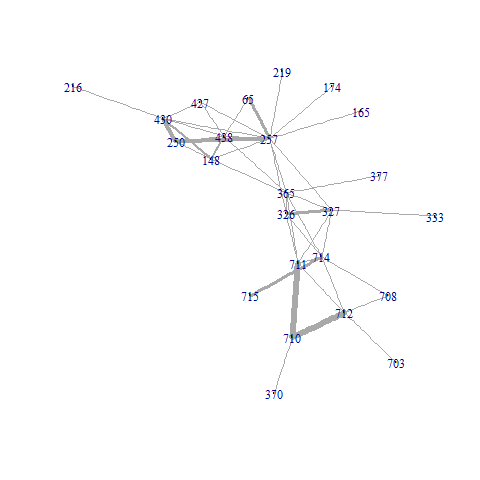

In [69]:
%%R -i edgelist_r
#install.packages("igraph", "C:/Program Files/R/R-3.2.3/library")
library(igraph)
g <- graph.data.frame(edgelist_r, directed=FALSE)
g <- simplify(g, remove.multiple = TRUE, remove.loops = TRUE)
coords <- layout.auto(g)
E(g)$weight = as.numeric(edgelist_r[,3])
plot(g, vertex.size=0, edge.width=E(g)$weight*10, margin=0, asp=0, 
     layout=coords, rescale=FALSE, xlim=range(coords[,1]), ylim=range(coords[,2]))

<font size="3">Knowledge base of the semicondctor firm (same graph as above, but prettier, realized in R, with the `qgraph` library)
<img src="knowledge_nocolor_circle.png" alt="kn" title="Title text"/>

### B. Communities (advanced topics)

<font size="3">Given a network, such as the network of co-invention (but also network of technologies, network of strategic alliances etc.), communities can be loosely defined as subsets (or clusters) of nodes such that
1. within each community there are many edges among nodes (i.e. the density of within-community links is high)
2. between communities there are fewer edges (i.e. the density of between-community links is lower). 

In other words, there must be more edges ‘inside’ the community than edges linking the community with the rest of the graph (Newman 2004). The recent advances in the science of networks have produced several methods to uncover communities in large graphs. Fortunato (2010) provides an exhaustive survey of the broad range of concepts and approaches in this field. 

In general, a problem that is common to the various methods is that they are computationally very demanding, especially when the size of the network becomes large. For this reason, several clustering techniques have been elaborated with the purpose of uncovering the community structure of large networks in a reasonable amount of time.

Broadly speaking, the existing techniques adopt the concept of **modularity**, originally proposed by Newman and Girvan (2004), as their starting point.

This notion captures the essence of the problem of detecting network communities and its intuition can be summarized as follows.

Given an arbitrary partition of the network into $k$ subsets (or communities) of nodes, one can define a  $k x k$  symmetric matrix $\mathbf{e}$ where the elements $e_{ij}$ represent the fraction of all edges in the network that link nodes in community $i$ to nodes in community $j$.

Then, the sum of any row (or column) of $\mathbf{e}$ –  i.e. $a_i=\sum_{j}e_{ij}$ – represents the fraction of all edges connected to nodes in the community $i$. Likewise, the sum of the elements of $\mathbf{e}$ on the main diagonal – i.e. $\sum_{i}e_{ii}$ – is the fraction of all edges that link nodes in the same community. 

For a random network, which intuitively is not expected to exhibit a community structure, the expected fraction of intra-community links is equal to $a_ia_i$, namely the probability that an edge starts at a node in $i$ times the probability that the same edge ends at a node in $i$. 

The modularity index is then defined as the difference between the fraction of edges that fall within communities and the expected value of the same quantity if edges were randomly distributed without regard for the community structure, namely:

$$Q=\sum_{i}\big(e_{ii}-a_{i}^{2}\big)$$

For a network without a community structure, the value of $Q$ is equal to zero. Similarly, it is straightforward that the value of $Q$ of the whole network, taken as a single community, is equal to zero. On the other hand, values different from zero indicate deviation from randomness. In particular, larger positive values of $Q$ suggest the existence of a significant community structure. If a high value of modularity corresponds to a good partition of nodes into communities, the partition that yields the maximum value of $Q$ should be the optimal one. Unfortunately, computing the optimal value of $Q$ is nearly impossible, due to the extreme complexity of the problem and the time it would take. Yet, several clustering algorithms have been proposed recently, which are able to find fairly good approximations.

Below, we apply the community detection algorithm suggested by Newman and Girvan (2004) based on the notion of **edge betweenness**. In particular, we apply the community detection algorithm to the knowledge network of the semiconductor firm in the period $1978-1982$.

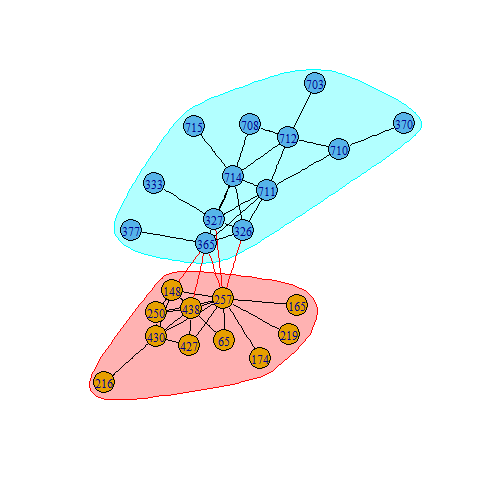

In [70]:
%%R -i edgelist_r
#install.packages("igraph", "C:/Program Files/R/R-3.2.3/library")
library(igraph)
g <- graph.data.frame(edgelist_r, directed=FALSE)
g <- simplify(g, remove.multiple = TRUE, remove.loops = TRUE)
coords <- layout.auto(g)
ceb <- cluster_edge_betweenness(g) 
plot(ceb, g)

<font size="3">The community detection algorithm reveals the existence of two major clusters of technologies. To get a sense of the meaning of these two clusters, refer to the contents of the various classes using the USPTO classification:
https://www.uspto.gov/web/patents/classification/selectnumwithtitle.htm

**Thank You!**